<a href="https://colab.research.google.com/github/vsolodkyi/NeuralNetworks_SkillBox/blob/main/module_12/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_2D_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практика

В этом практическом задании вы реализуете GAN, которые научится генерировать данные из такого распределения:
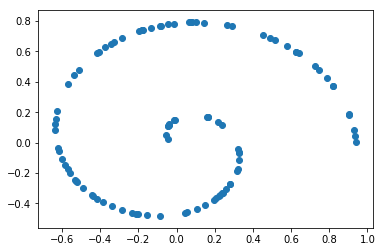

In [ ]:
import tensorflow as tf
tf.enable_eager_execution()
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm

Основные функции из прошлого урока приводятся без изменений (просто выполните клетку ниже)

In [ ]:
#@title (вспомогательный код -- выполните клетку)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(discr_pred_fake_data):
    """
    discr_pred_fake_data -- предсказания дискриминатора на фейковых данных
    """
    labels = tf.ones_like(discr_pred_fake_data)
    # для генератора "хорошо", 
    # когда фейковые данные дискриминатор назвал реальными
    return cross_entropy(labels, discr_pred_fake_data) 

def discriminator_loss(disc_pred_real_data, disc_pred_fake_data):
    """
    disc_pred_real_data -- логиты, предсказанные дискриминатором для реальных данных
    disc_pred_fake_data -- логиты, предсказанные дискриминатором для фейковых данных
    """
    real_labels = tf.ones_like(disc_pred_real_data) # правильные ответ для реальных данных -- 1
    fake_labels = tf.zeros_like(disc_pred_fake_data) # правильные ответ для фейковых данных -- 0
    
    real_loss = cross_entropy(real_labels, disc_pred_real_data)
    fake_loss = cross_entropy(fake_labels, disc_pred_fake_data)

    total_loss = real_loss + fake_loss
    return total_loss

def generate_latent_points(latent_dim, n):
	x_input = np.random.randn(n,  latent_dim)
	return x_input

def generate_fake_samples(generator, n):
    x_input = generate_latent_points(generator.input_shape[1], n)
    X = generator.predict(x_input)
    return X

def show_result(generator, title=""):
    X_fake = generate_fake_samples(generator=generator, n=100)
    X_real = generate_real_samples(n=100)  
    plt.figure()
    plt.title(title)
    plt.scatter(X_real[:, 0], X_real[:, 1], label="real samples")
    plt.scatter(X_fake[:, 0], X_fake[:, 1], label="generated samples")
    plt.legend(loc="best")
    plt.show()

def train_step(discriminator, generator, optimizer, batch_size=128):
    half_batch = int(batch_size / 2)	
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 1. Сэмплируем batch_size/2 точек из реального распределения
        X_real = generate_real_samples(n=half_batch)
        
        # генератор генерирует данные из латентных векторов, которые принадлежат простому распределению
        # и учится превращать их в распределени которое сможет обмануть дискриминатор
        # сначала генерируем латентные вектора -- 
        latent_z = np.random.randn(half_batch,  generator.input_shape[1])
        # а затем превращаем их с помощью генератора в X_fake
        X_fake = generator(latent_z)
        
        # 3. Делаем forward_pass дискриминатора на x_real и x_fake, 
        # получив discr_pred_real_data и discr_pred_fake_data
        discr_pred_real_data = discriminator(X_real)
        discr_pred_fake_data = discriminator(X_fake)

        # 4. Посчитать лосс дискриминатора и генератора
        disc_loss = discriminator_loss(discr_pred_real_data, discr_pred_fake_data)
        gen_loss = generator_loss(discr_pred_fake_data)
    
    # считаем производные
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    # 5. Обновляем параметры генератора и дискриминатора. 
    optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return disc_loss.numpy(), gen_loss.numpy()

def train_gan(discriminator, generator, optimizer, n_epochs=10000, n_batch=128,
              show_every=1000):
    losses_hist_disc = []
    losses_hist_gen = []
    for i in tqdm(range(n_epochs)):
        if i % show_every == 0:
            show_result(generator=generator, title=f"Epoch {i}")
            
        disc_loss, gen_loss = train_step(discriminator, generator, optimizer, n_batch)
        losses_hist_disc.append(disc_loss)
        losses_hist_gen.append(gen_loss)
    return losses_hist_disc, losses_hist_gen

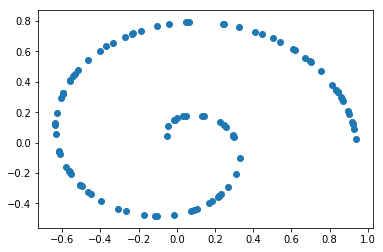

In [ ]:
def spirals(n_points, noise=0):
    """
    adapted from https://glowingpython.blogspot.com/2017/04/solving-two-spirals-problem-with-keras.html
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 360*1.5 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return np.hstack((d1x, d1y)) / 10.

def generate_real_samples(n=100):
    return spirals(n_points=n, noise=0)

original = generate_real_samples(100)
plt.scatter(original[:,0], original[:,1])
plt.show()

**Задание**

Подберите архитектуру генератора и дискриминатора таким образом, чтобы научиться генерировать данные из указанного распределения.

In [ ]:
def build_generator(latent_dim, n_outputs=2):
    # <YOUR CODE STARTS HERE >
    # Реализуйте генератор. 
    # Т.к. данные находятся в промежутке от -1 до 1, то можно добавить такие ограничения в сеть 
    # с помощью функции активации -- tanh (как сигмоида, только превращает выходы в промежуток от -1 до 1)
    # Мне это помогло ускорить сходимость. Использовать ее необязательно. 
    # Последний слой можно оставить без изменений

    



    # <YOUR ENDS STARTS HERE >
    model.add(tf.keras.layers.Dense(n_outputs, activation="tanh"))
    return model

def build_discriminator(n_inputs=2):
    # <YOUR CODE STARTS HERE >
    # Реализуйте дискриминатор. Лосс работает с логитами -- поэтому не забудьте убрать активацию с последнего слоя.
    
    



    
    # <YOUR CODE ENDS HERE >
    
    return model

# вы можете изменить этот параметр
latent_dim = 10

generator = build_generator(latent_dim=latent_dim, n_outputs=2)
discriminator = build_discriminator(n_inputs=2)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5) # параметры оптимизатора можно тоже менять, но 
                                                                      # но и с этими может получиться :)

losses_hist_disc, losses_hist_gen = train_gan(discriminator, generator, optimizer, n_epochs=10000,
          show_every=1000)    

In [ ]:
show_result(generator=generator)
show_result(generator=generator)